# Team Members:
- Chenrui Fan
- Xipeng Wang
- Soi Zhi Wen

In [ ]:
# Upload the dataset to Google Drive and mount it to Colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Privacy/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset: https://archive.ics.uci.edu/dataset/856/higher+education+students+performance+evaluation

Analyse the Sex and Grade column, the column names are "2" and "GRADE" respectively.

Class Labels:

Student ID

2- Sex (1: female, 2: male)

32- GRADE (0: Fail, 1: DD, 2: DC, 3: CC, 4: CB, 5: BB, 6: BA, 7: AA)

# Data Loading & Visualizing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('DATA.csv')
df[['2', 'GRADE']] = df[['2', 'GRADE']].astype('int64')

In [ ]:
# simple automated pipeline that performs the analysis with the data as input
def show(data_show):
  fig, ax = plt.subplots(1, 3, figsize=(20, 6))

  sns.boxplot(x='2', y='GRADE', data=data_show, ax=ax[0])
  ax[0].set_title('Boxplot of OUTPUT Grade by Gender')
  ax[0].set_xlabel('Gender')
  ax[0].set_ylabel('OUTPUT Grade')

  sns.violinplot(x='2', y='GRADE', data=data_show, ax=ax[1])
  ax[1].set_title('Violin Plot of OUTPUT Grade by Gender')
  ax[1].set_xlabel('Gender')
  ax[1].set_ylabel('OUTPUT Grade')

  sns.barplot(x='2', y='GRADE', data=data_show, ax=ax[2])
  ax[2].set_title('Bar Plot of OUTPUT Grade by Gender')
  ax[2].set_xlabel('Gender')
  ax[2].set_ylabel('OUTPUT Grade')

  plt.tight_layout()

  plt.show()

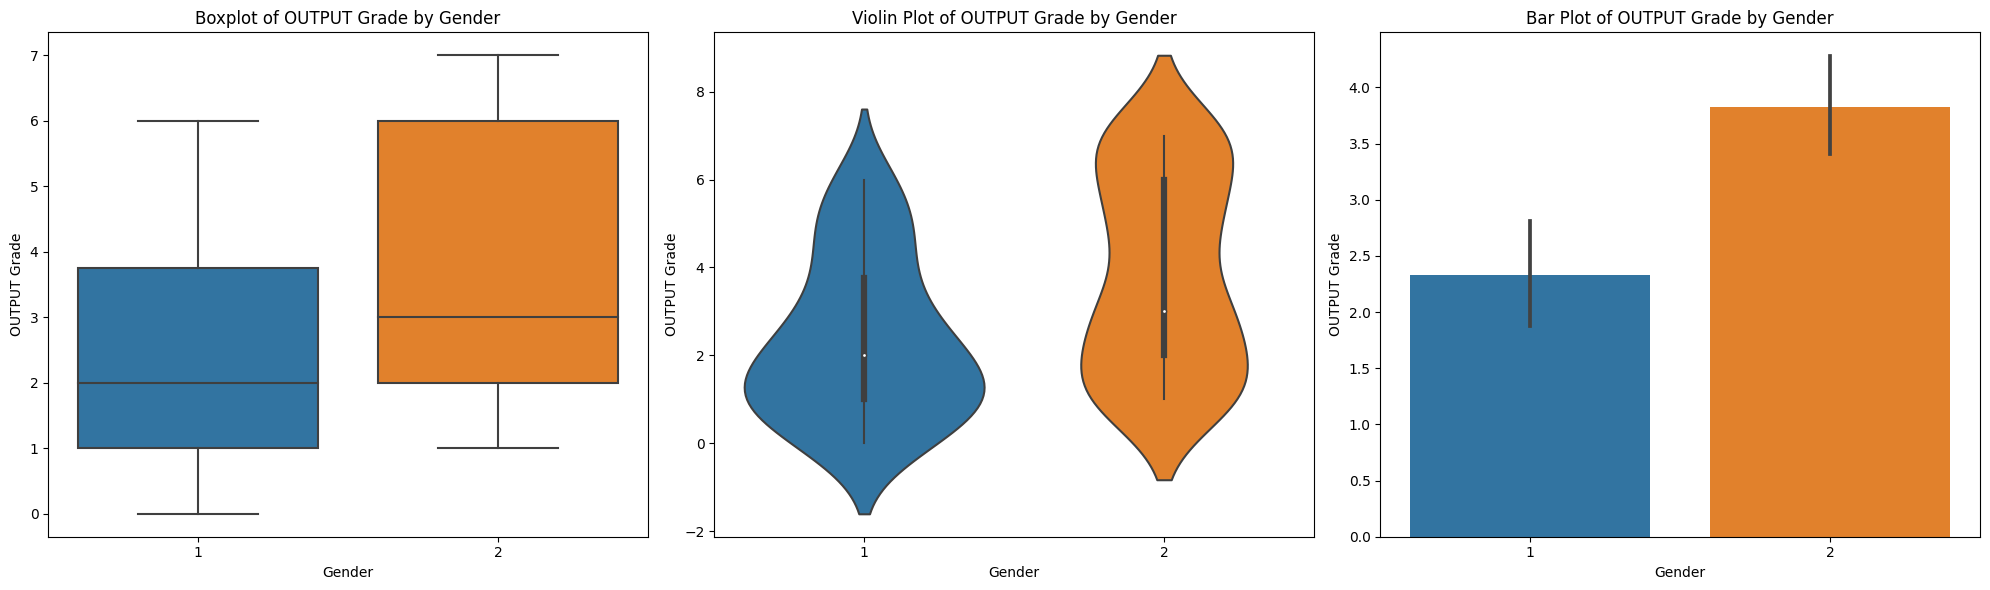

In [ ]:
show(df)

# Laplace Mechanism

In [ ]:
# !pip install diffprivlib

Private average: -6.7749091443640985
Private variance: 4.617347487937866


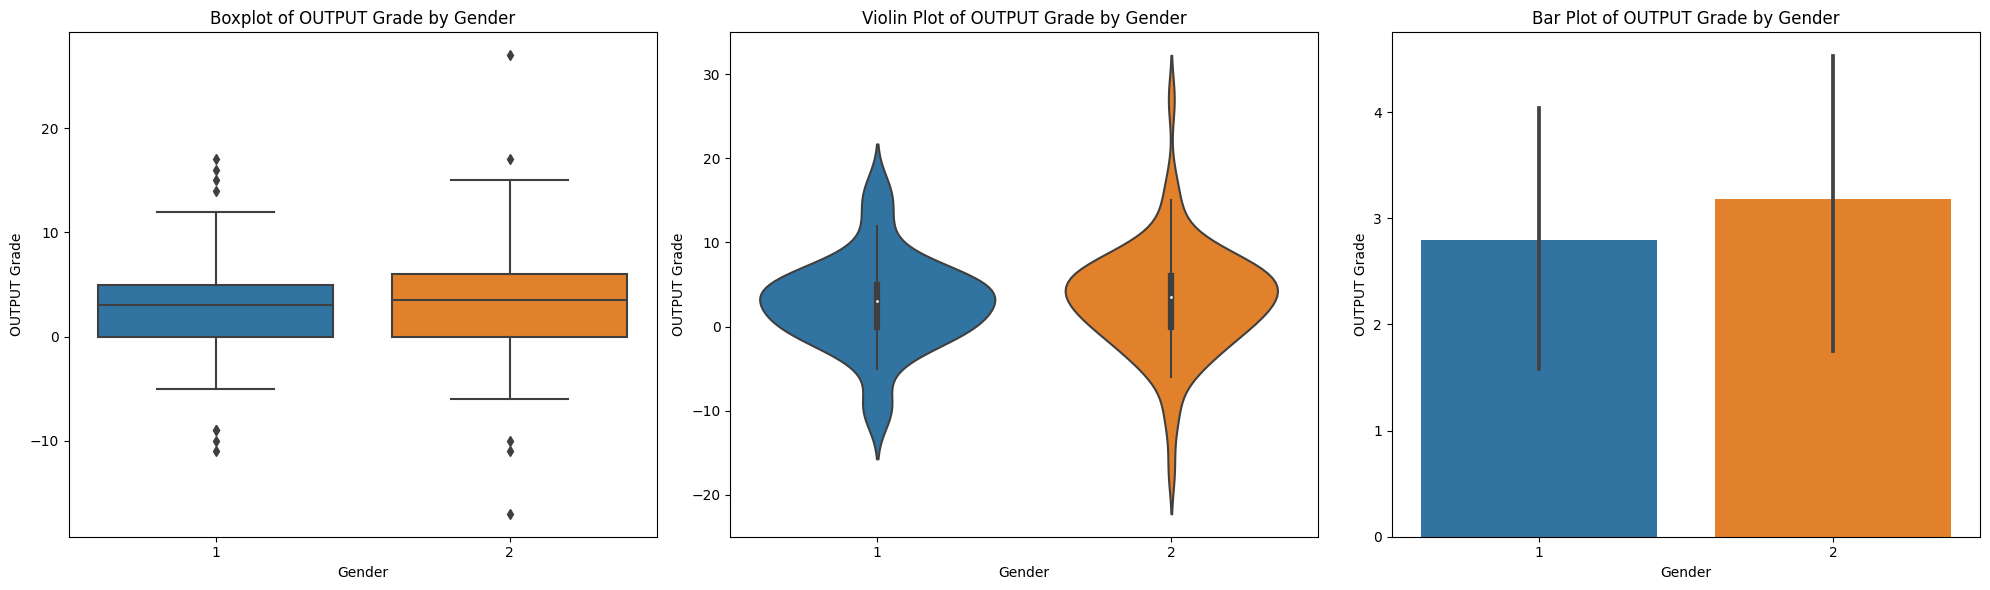

In [ ]:
from diffprivlib.mechanisms import Laplace
import numpy as np

def laplace(data, epsilon, sensitivity):

    # create Laplace instance
    laplace_mechanism = Laplace(epsilon=epsilon, sensitivity=sensitivity)

    # Use Laplace mechanism to add Laplace noise to calculate the mean
    private_mean = laplace_mechanism.randomise(np.mean(data))

    # Use Laplace mechanism to add Laplace noise to calculate the variance
    private_var = laplace_mechanism.randomise(np.var(data))

    # Add noise to the data
    private_data = [[round(laplace_mechanism.randomise(x)), round(laplace_mechanism.randomise(y))] for [x, y] in data]

    # let Sex and Grade between (1,2) and (0,7)
    for i in range(len(private_data)):
      if private_data[i][0] < 1:
        private_data[i][0]  =  1
      elif private_data[i][0] > 2:
        private_data[i][0]  =  2

    return private_mean, private_var, private_data

data = df[['2', 'GRADE']].to_numpy()
epsilon = 0.01

# Here we calculate the sensitivity
sensitivity = np.mean(data.max(axis=0) - data.min(axis=0)) / len(data)

private_avg, private_var, private_data = laplace(data, epsilon, sensitivity)

print("Private average:", private_avg)
print("Private variance:", private_var)

# Convert a list to a Pandas DataFrame and then visualize it
private_data_df = pd.DataFrame(private_data, columns=['2', 'GRADE'])
show(private_data_df)

here epsilon = 0.01, result is nice

# Random-Response mechanism

In [ ]:
import numpy as np

def rp_binary(data: np.array, epsilon: float):

    # Basic implementation
    n_people = data.shape[0]
    n_features = data.shape[1]

    p = epsilon
    private_data = data.copy()
    flip_bits = np.random.choice(2, p=[1 -p, p], size=[n_people, n_features])
    private_data = private_data ^ flip_bits

    return private_data

def rp_float(data: np.array, epsilon: np.float, bound: np.array):

    n_people = data.shape[0]
    n_features = data.shape[1]
    private_data = data.copy()
    epsilon_i = epsilon / n_features
    sensitivity = bound

    return private_data

<ipython-input-125-cd6b888636b0>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def rp_float(data: np.array, epsilon: np.float, bound: np.array):


In [ ]:
# let Sex and Grade between (1,2) and (0,7)
def get_between(private_data):
  for i in range(len(private_data)):
    if private_data[i][0] < 1:
      private_data[i][0]  =  1
    elif private_data[i][0] > 2:
      private_data[i][0]  =  2

    if private_data[i][1] < 0:
      private_data[i][1]  =  0
    elif private_data[i][1] > 7:
      private_data[i][1]  =  7

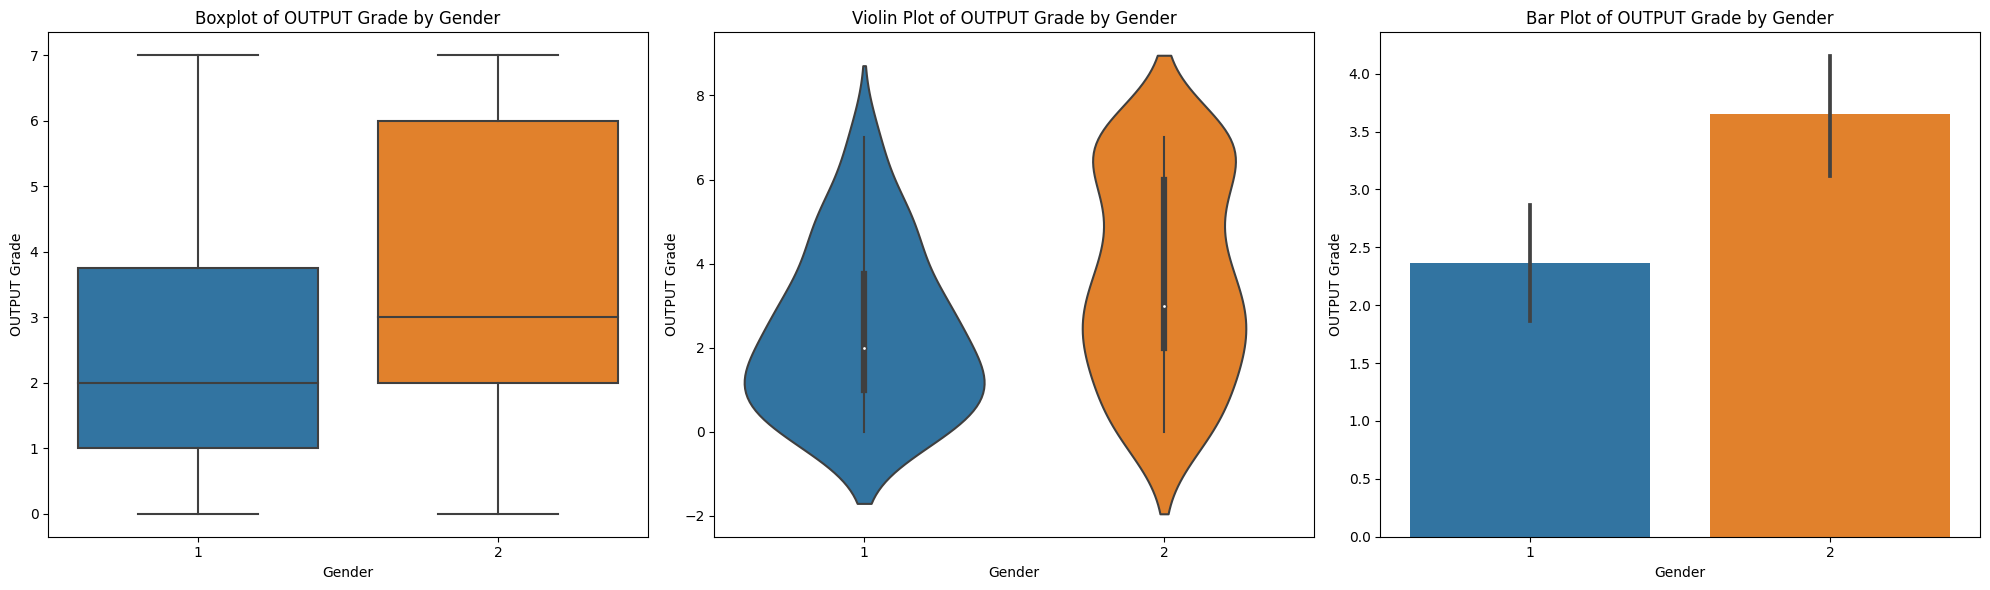

In [ ]:
data_RP = rp_binary(data, 0.4)
get_between(data_RP)

data_RP_df = pd.DataFrame(data_RP, columns=['2', 'GRADE'])
show(data_RP_df)

# Test different epsilon for RP

In [ ]:
means_x, means_y = np.transpose([np.mean(rp_binary(data, p), axis=0 ) for p in np.arange(0, 1, 0.01)])
means_all = means_x + means_y

Text(0.5, 1.0, 'means_Grade by p')

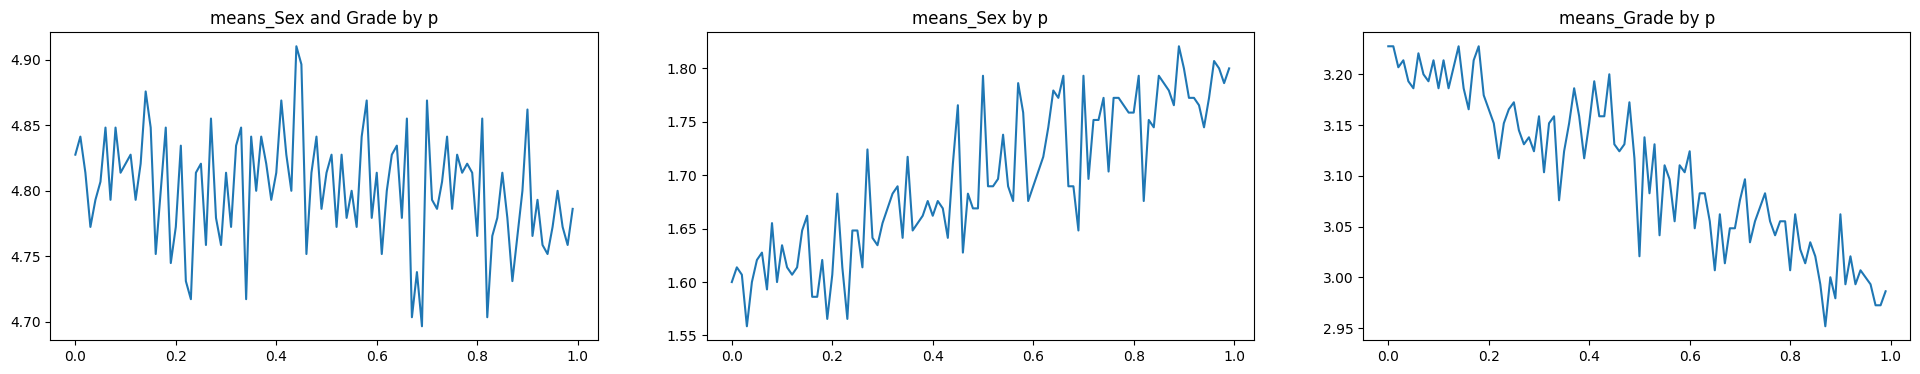

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 4))

axes[0].plot(np.arange(0, 1, 0.01), means_all)
axes[0].set_title('means_Sex and Grade by p')

# only print x by diffirent p:
axes[1].plot(np.arange(0, 1, 0.01), means_x)
axes[1].set_title('means_Sex by p')

# only print y by diffirent p:
axes[2].plot(np.arange(0, 1, 0.01), means_y)
axes[2].set_title('means_Grade by p')